`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [1]:
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
from dask.diagnostics import ProgressBar
from xgcm import Grid
from xhistogram.xarray import histogram
import pandas as pd
import scipy

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

variables = ['areacello']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Ofx'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gr = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

# dd_gr = merge_variables(dd_gr)

# temp={}
# for name,item in dd_gr.items():
#     #print(name)
#     #print(item.data_vars)
#     present = item.data_vars
#     if all(i in present for i in variables):
#         #print(name)
#         temp[name]=item
# dd_gr = temp
# list(dd_new_gr.keys())

dd_gr = combine_datasets(
    dd_gr,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gr.keys())
# dd_new_new_gr


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['GFDL-ESM4.gr.historical.Ofx']

# `A` is area averaged over entire x

In [3]:
A = dd_gr['GFDL-ESM4.gr.historical.Ofx'].mean([ 'x'],keep_attrs=True).areacello
A

<xarray.DataArray 'areacello' (y: 180)>
dask.array<mean_agg-aggregate, shape=(180,), dtype=float32, chunksize=(180,), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    cell_methods:   area: sum
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Grid-Cell Area
    original_name:  areacello
    standard_name:  cell_area
    units:          m²

# `A_pac` is area averaged over Pacific Basin

In [36]:
A_pac = dd_gr['GFDL-ESM4.gr.historical.Ofx'].isel(x=slice(180,200)).mean('x', keep_attrs=True).areacello
A_pac

<xarray.DataArray 'areacello' (y: 180)>
dask.array<mean_agg-aggregate, shape=(180,), dtype=float32, chunksize=(180,), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    cell_methods:   area: sum
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Grid-Cell Area
    original_name:  areacello
    standard_name:  cell_area
    units:          m²

In [6]:
newcoords = {'x':dd_gr['GFDL-ESM4.gr.historical.Ofx'].areacello['x'], 'y':dd_gr['GFDL-ESM4.gr.historical.Ofx'].areacello['y']}
newcoords
# newcoords2 = {'y':dd_gr['GFDL-ESM4.gr.historical.Ofx'].mean(['x'],keep_attrs=True).areacello['y']}
# newcoords2

{'x': <xarray.DataArray 'x' (x: 360)>
 array([  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5])
 Coordinates:
   * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
 Attributes:
     axis:           X
     bounds:         lon_bnds
     cell_methods:   time: point
     long_name:      longitude
     standard_name:  longitude
     units:          degrees_E,
 'y': <xarray.DataArray 'y' (y: 180)>
 array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
        -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
        -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
        -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
        -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
        -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
        -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
        -19.5, -18.5, -17.5, -16.5,

In [7]:
dd = {}
dd['UKESM1-0-LL.gn.historical.Omon'] = xr.open_mfdataset('UKESM1_*_20yr.nc')
dd['CanESM5-CanOE.gn.historical.Omon']= xr.open_mfdataset('CanESM5CanOE*_20yr.nc')
dd['CNRM-ESM2-1.gn.historical.Omon']= xr.open_mfdataset('CNRM*_20yr.nc')
dd['CanESM5.gn.historical.Omon']= xr.open_mfdataset('CanESM5_*_20yr.nc')
dd['IPSL-CM6A-LR.gn.historical.Omon']= xr.open_mfdataset('IPSL*_20yr.nc')
dd['CESM2-WACCM.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM_*_20yr.nc')
dd['CESM2.gr.historical.Omon']= xr.open_mfdataset('CESM2_*_20yr.nc')
dd['CESM2-WACCM-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM-FV2_*_20yr.nc')
dd['GFDL-ESM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-ESM4_*_20yr.nc')
dd['CESM2-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-FV2_*_20yr.nc')
dd['GFDL-CM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-CM4_*_20yr.nc')
dd['MRI-ESM2-0.gr.historical.Omon']= xr.open_mfdataset('MRI-ESM2-0_*_20yr.nc')
# A = xr.open_mfdataset('AREA.nc')

In [8]:
for name, ds in dd.items():
    ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['p'])
    ds['sigma2'] = gsw.sigma2(ds['so'],ds['thetao'])

In [9]:
for name, ds in dd.items():
    dd[name] = ds.assign_coords(**newcoords)

In [10]:
dd_x = {}
dd_x['UKESM1-0-LL.gn.historical.Omon'] = xr.open_mfdataset('UKESM1_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CanESM5-CanOE.gn.historical.Omon']= xr.open_mfdataset('CanESM5CanOE*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CNRM-ESM2-1.gn.historical.Omon']= xr.open_mfdataset('CNRM*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CanESM5.gn.historical.Omon']= xr.open_mfdataset('CanESM5_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['IPSL-CM6A-LR.gn.historical.Omon']= xr.open_mfdataset('IPSL*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CESM2-WACCM.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CESM2.gr.historical.Omon']= xr.open_mfdataset('CESM2_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CESM2-WACCM-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM-FV2_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['GFDL-ESM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-ESM4_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['CESM2-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-FV2_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['GFDL-CM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-CM4_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)
dd_x['MRI-ESM2-0.gr.historical.Omon']= xr.open_mfdataset('MRI-ESM2-0_*_20yr.nc').isel(x=slice(180,200)).mean('x', keep_attrs=True)

for name, ds in dd_x.items():
    da = dd[name]
    ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
    ds['insitutemp'] = gsw.t_from_CT(da['so'], da['thetao'], ds['p']).isel(x=slice(180,200)).mean('x', keep_attrs=True)
    ds['sigma2'] = gsw.sigma2(da['so'],da['thetao']).isel(x=slice(180,200)).mean('x', keep_attrs=True)
    


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

In [15]:
newercoords = {'y':dd_gr['GFDL-ESM4.gr.historical.Ofx'].areacello['y']}

for name, ds in dd_x.items():
    dd_x[name] = ds.assign_coords(**newercoords)


In [16]:
PCO2_x = {}
for name, ds in dd_x.items():
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds['talk']*conversion,par2=ds['dissic']*conversion,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds['thetao'], pressure = ds['p'], 
                        temperature = ds['insitutemp'])
    PCO2_x[name] = results['pCO2_out']

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

# Trying to get PCO2 in density space
## `PCO2_sigma` is PCO2 in density space for Pacific Basin

In [17]:
from xgcm import Grid

grid = Grid(ds, coords={'Z': {'center':'lev'}}, periodic=False)
target = np.linspace(35.5, 37, 35)

# fig, axarr = plt.subplots(nrows = 6, ncols = 2, figsize=[20,20])
# fig.tight_layout(pad = 3.5)
# plt.rc('font', size = 14)
# plt.rc('axes', titlesize= 14)    
# plt.rc('axes', labelsize= 14)
# plt.rc('figure', titlesize=16)

# ax_idx = 0

PCO2_sigma = {}

for name, ds in dd_x.items():

#     ax = axarr.flat[ax_idx]
    
    DIC = grid.transform(ds['dissic'], 'Z', target, target_data=ds['sigma2'], method = 'linear').transpose('sigma2','y')
    TALK = grid.transform(ds['talk'], 'Z', target, target_data=ds['sigma2'], method = 'linear').transpose('sigma2','y')
    THETAO = grid.transform(ds['thetao'], 'Z', target, target_data=ds['sigma2'], method = 'linear').transpose('sigma2','y')
    P = grid.transform(ds['p'], 'Z', target, target_data=ds['sigma2'], method = 'linear').transpose('sigma2','y')
    TEMP = grid.transform(ds['insitutemp'], 'Z', target, target_data=ds['sigma2'], method = 'linear').transpose('sigma2','y')
    conversion =  1e6/1035
    results = pyco2.sys(par1=TALK*conversion,par2=DIC*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = THETAO, pressure = P, 
                    temperature = TEMP)

    PCO2_sigma[name] = DIC.copy(data=results['pCO2_out'])
#     ax.set_xlim([-80,-30])
#     im = ax.pcolormesh(ppco2['y'],ppco2['sigma2'], ppco2, vmin = 300, vmax = 600)
#     cbar = plt.colorbar(im,ax=ax)
#     cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
#     ax.invert_yaxis()
#     ax.set_title(name)
#     ax.set_xlabel('Latitude')
#     ax.set_ylabel('Potential Density - 1000 kg/m\u00b3')
#     ax_idx += 1

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered

In [39]:
ds.sigma2

<xarray.DataArray 'sigma2' (sigma2: 35)>
array([35.5     , 35.544118, 35.588235, 35.632353, 35.676471, 35.720588,
       35.764706, 35.808824, 35.852941, 35.897059, 35.941176, 35.985294,
       36.029412, 36.073529, 36.117647, 36.161765, 36.205882, 36.25    ,
       36.294118, 36.338235, 36.382353, 36.426471, 36.470588, 36.514706,
       36.558824, 36.602941, 36.647059, 36.691176, 36.735294, 36.779412,
       36.823529, 36.867647, 36.911765, 36.955882, 37.      ])
Coordinates:
  * sigma2   (sigma2) float64 35.5 35.54 35.59 35.63 ... 36.87 36.91 36.96 37.0

### PCO2 on 35.7 isopycnal zonally averaged

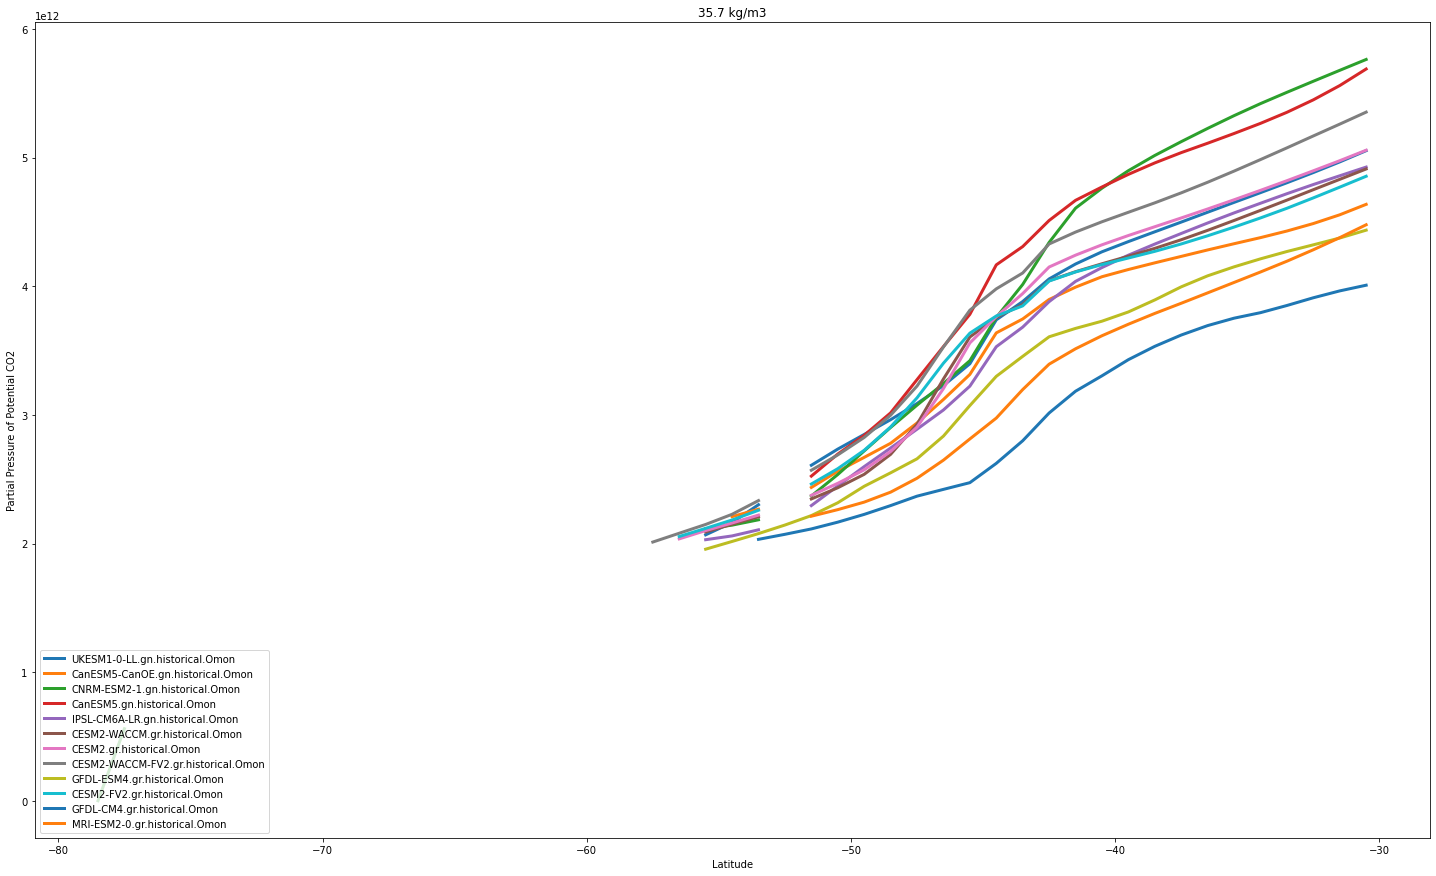

In [45]:
for name, ds in PCO2_sigma.items():
    plt.plot(ds.y[10:60], A_pac[10:60]*ds.sel(sigma2 = 35.7, method = 'nearest')[10:60], label = name, lw = 3)
    plt.xlabel('Latitude')
    plt.ylabel('Partial Pressure of Potential CO2')

plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='lower left'
#     , borderaxespad=0.
)
plt.title('35.7 kg/m3')
plt.rcParams["figure.figsize"] = (25,15)

### PCO2 on 36.029412 isopycnal zonally averaged

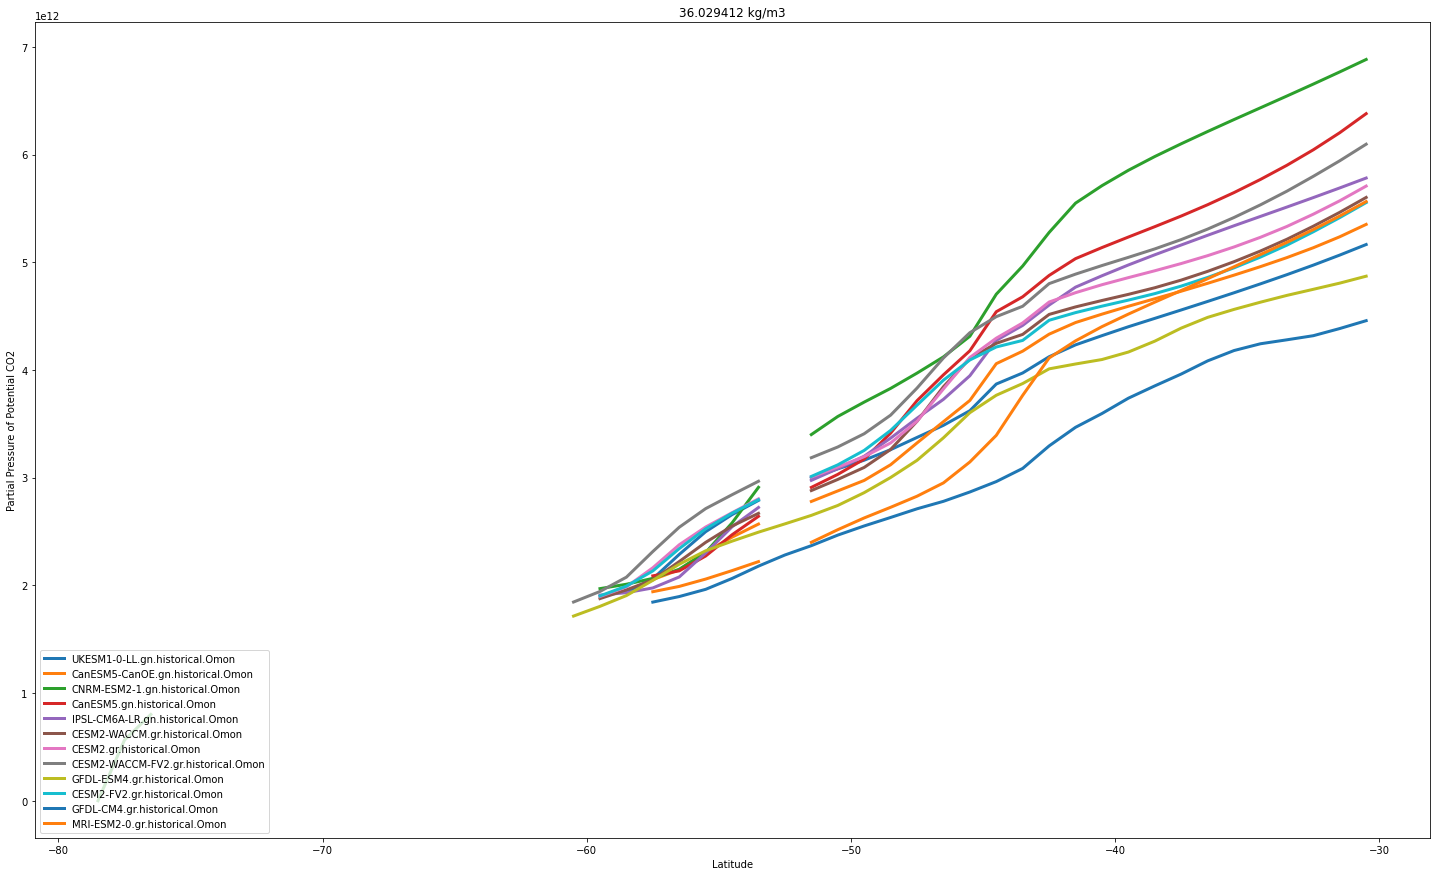

In [44]:
for name, ds in PCO2_sigma.items():
    plt.plot(ds.y[10:60], A_pac[10:60]*ds.sel(sigma2 = 36.029412, method = 'nearest')[10:60], label = name, lw = 3)
    plt.xlabel('Latitude')
    plt.ylabel('Partial Pressure of Potential CO2')

plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='lower left'
#     , borderaxespad=0.
)
plt.title('36.029412 kg/m3')
plt.rcParams["figure.figsize"] = (25,15)

# Zonally averaged surface upward flux of CO2

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

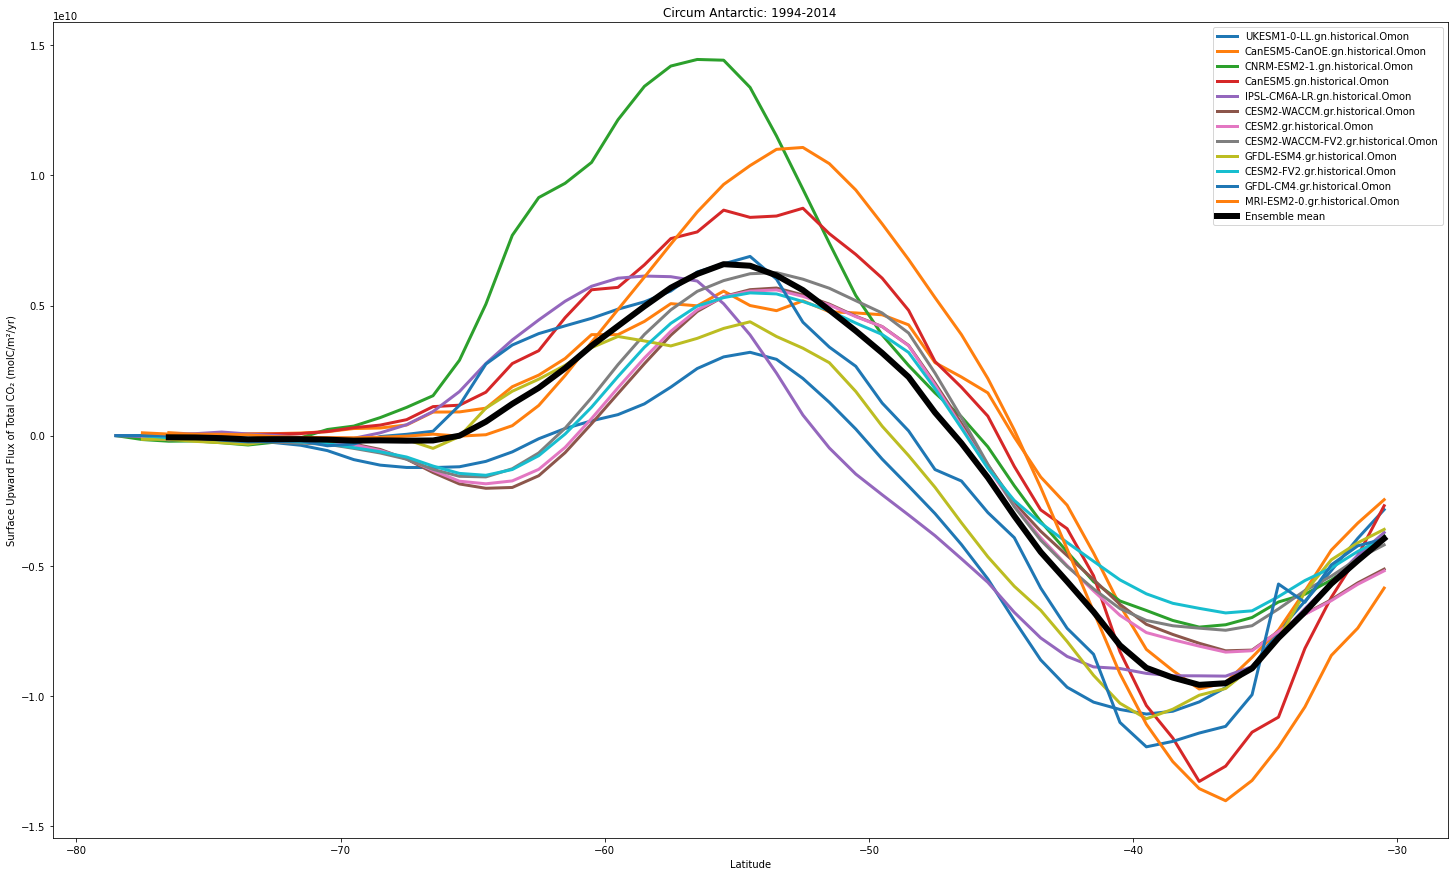

In [28]:
# d = dd['GFDL-CM4.gr.historical.Omon'].fgco2.mean(['x'],keep_attrs=True)
# d*A
temp = {}

conversion = 3.1536e7 * 83.3
for name, ds in dd.items():
    d = -1*ds.fgco2.mean(['x'],keep_attrs=True)*conversion
    ar = d*A
    temp[name]=ar
    

for name, ds in temp.items():
    plt.plot(ds.y[10:60], ds[10:60], label = name, lw = 3)
    plt.xlabel('Latitude')
    plt.ylabel('Surface Upward Flux of Total CO\u2082 (molC/m\u00b2/yr)')
    
mn = np.mean(list(temp.values()), axis=0)
plt.plot(ds.y[10:60], mn[10:60], lw = 6, label = 'Ensemble mean', color = 'black')
plt.xlabel('Latitude')
plt.ylabel('Surface Upward Flux of Total CO\u2082 (molC/m\u00b2/yr)')
# zr = xr.zeros_like(dd['CESM2-FV2.gr.historical.Omon'].fgco2)
# zr.isel(x = 0)[10:60].plot(linestyle = 'dashed', color = 'black')
# plt.xlabel('Latitude')
# plt.ylabel('Surface Upward Flux of Total CO\u2082 * Area (molC/yr)')

plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='upper right'
#     , borderaxespad=0.
)
plt.title('Circum Antarctic: 1994-2014')
plt.rcParams["figure.figsize"] = (25,15)

In [40]:
B = dd['CNRM-ESM2-1.gn.historical.Omon'].fgco2.mean(['x'],keep_attrs=True)


In [23]:
newcoords2 = {'y':dd_gr['GFDL-ESM4.gr.historical.Ofx'].mean(['x'],keep_attrs=True).areacello['y']}
B.assign_coords(**newcoords2)

<xarray.DataArray 'fgco2' (y: 180)>
dask.array<mean_agg-aggregate, shape=(180,), dtype=float64, chunksize=(180,), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

In [25]:
B.y

<xarray.DataArray 'y' (y: 180)>
array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
       -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
       -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
       -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
       -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
       -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
       -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
       -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,
        -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
         0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
        10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,  18.5,  19.5,
        20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,  27.5,  28.5,  29.5,
        30.5,  31.5,  32.5,  33.5,  34.5,  35.5,  36.5,  37.5,  38.5,  39.5,
        40.5,  41.5,  42.5,  43.5,  44.5,  45.5,  46.5,  47.5,  48.5,  49.5,
        50.5,  51.5,  52.5,  53.5,  54.5,  55.5,  56.5,  57.5,  58.5,  59.5,
        60.5,  61.5,  62.5,  63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,
        70.5,  71.5,  72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,
        80.5,  81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5])
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    standard_name:  latitude

In [26]:
A.y

<xarray.DataArray 'y' (y: 180)>
array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
       -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
       -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
       -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
       -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
       -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
       -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
       -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,
        -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
         0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
        10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,  18.5,  19.5,
        20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,  27.5,  28.5,  29.5,
        30.5,  31.5,  32.5,  33.5,  34.5,  35.5,  36.5,  37.5,  38.5,  39.5,
        40.5,  41.5,  42.5,  43.5,  44.5,  45.5,  46.5,  47.5,  48.5,  49.5,
        50.5,  51.5,  52.5,  53.5,  54.5,  55.5,  56.5,  57.5,  58.5,  59.5,
        60.5,  61.5,  62.5,  63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,
        70.5,  71.5,  72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,
        80.5,  81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5])
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    axis:           Y
    bounds:         lat_bnds
    cell_methods:   time: point
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_N

In [41]:
B*A

<xarray.DataArray (y: 180)>
dask.array<mul, shape=(180,), dtype=float64, chunksize=(180,), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

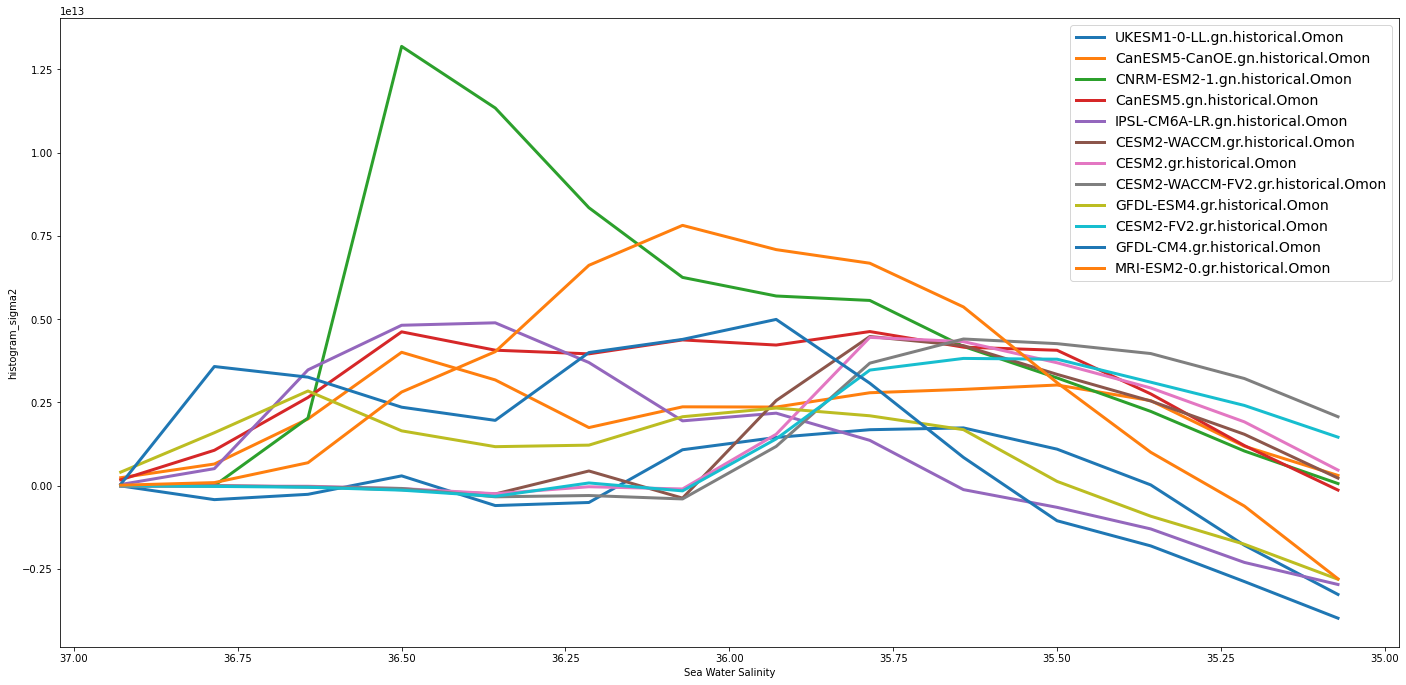

In [46]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=[20,10])
fig.tight_layout(pad = 3.5)
plt.rc('font', size = 14)
plt.rc('axes', titlesize= 14)    
plt.rc('axes', labelsize= 12)
plt.rc('figure', titlesize=16)

target = np.linspace(35, 37, 15)
binz = np.linspace(35, 37, 15)

conversion = 3.1536e7 * 83.3
ax_idx = 0
# for name, ds in dd.items():
for name, ds in dd.items():
#     ax = axarr.flat[ax_idx]
#     if name != 'GFDL-ESM4.gr.historical.Omon':
#         if name != 'GFDL-CM4.gr.historical.Omon':
    h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
    h2.plot(label = name, lw = 3)
ax.invert_xaxis()
#     ax.set_title(name)
#     ax_idx += 1
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='upper right'
#     , borderaxespad=0.
)

In [51]:
ds = dd['CESM2-FV2.gr.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
# h2.plot(label = name)
h2.sigma2_bin

<xarray.DataArray 'sigma2_bin' (sigma2_bin: 14)>
array([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
       35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
       36.785714, 36.928571])
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 35.07 35.21 35.36 ... 36.64 36.79 36.93
Attributes: (12/18)
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    Sea water salinity is the salt content of sea water, ofte...
    frequency:      mon
    id:             so
    ...             ...
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Water Salinity
    type:           real
    variable_id:    so

([<matplotlib.axis.XTick at 0x7fb097a11fa0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

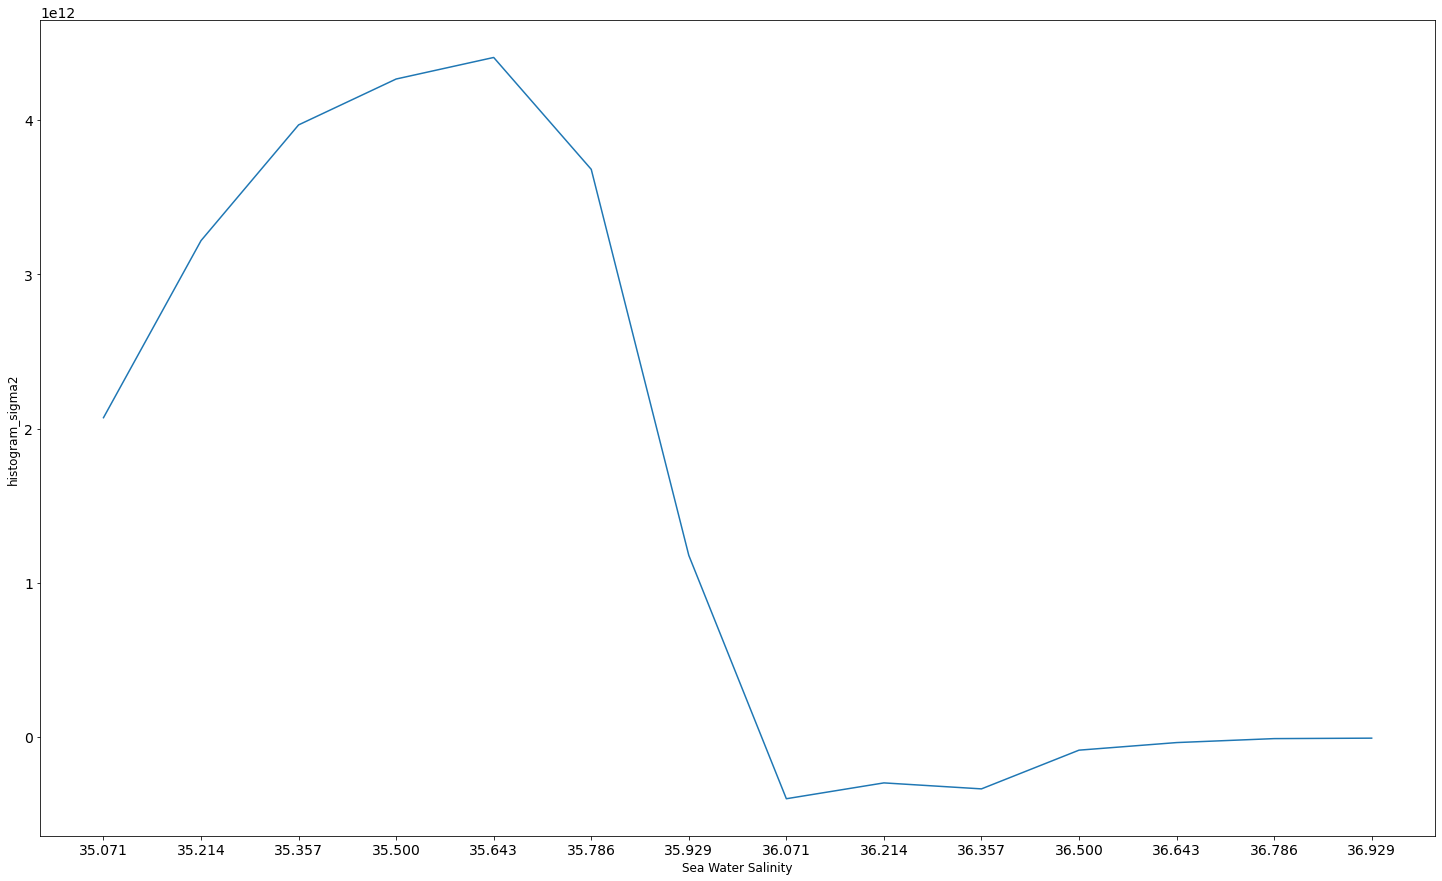

In [53]:
ds = dd['CESM2-WACCM-FV2.gr.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
h2.plot(label = name)
plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
       35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
       36.785714, 36.928571])

([<matplotlib.axis.XTick at 0x7fb097ab4ee0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

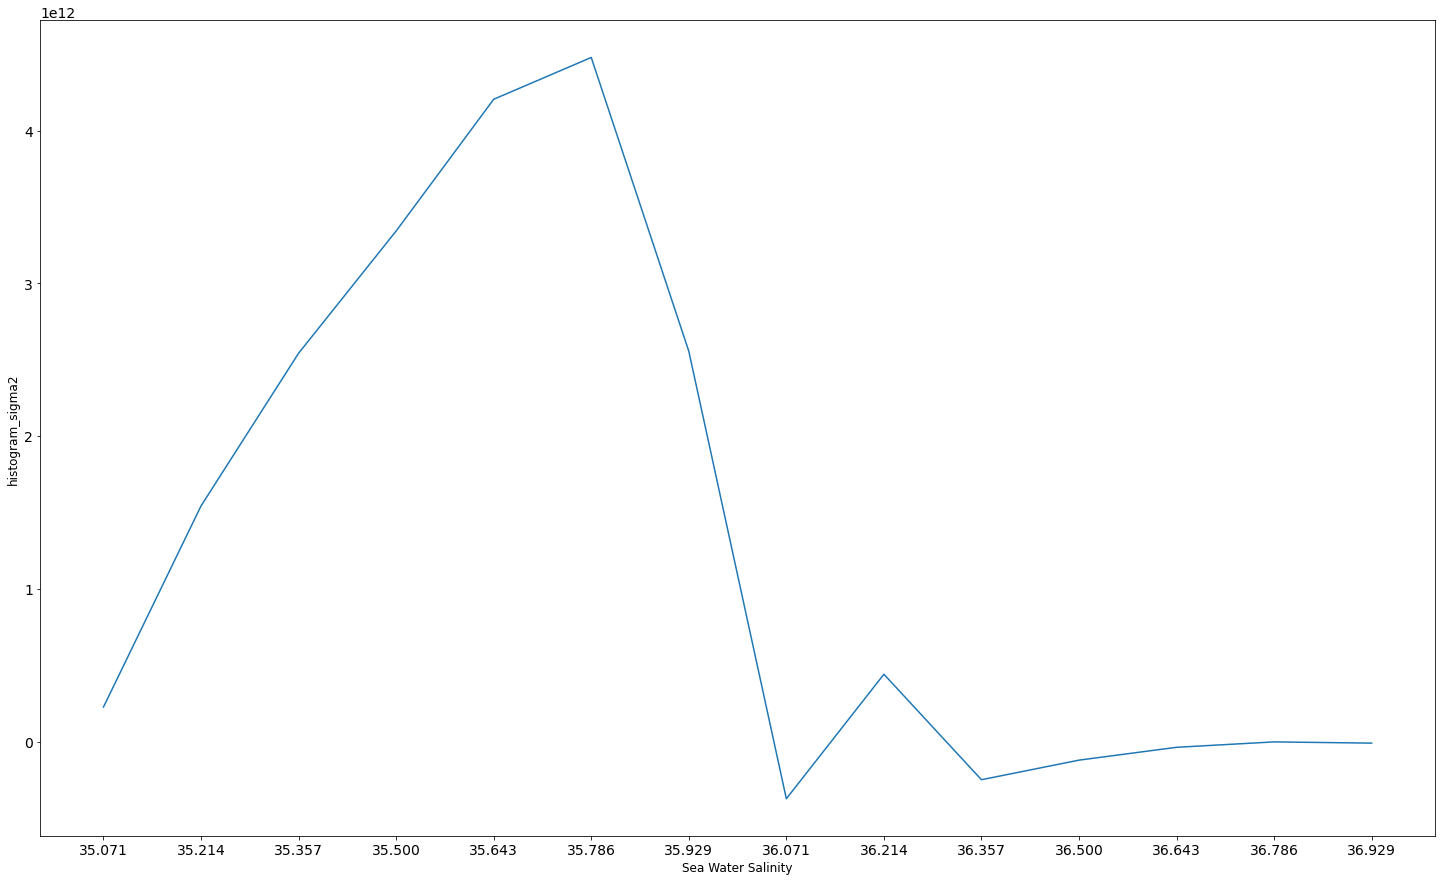

In [54]:
ds = dd['CESM2-WACCM.gr.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
h2.plot(label = name)
plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
       35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
       36.785714, 36.928571])

([<matplotlib.axis.XTick at 0x7fb099cff310>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

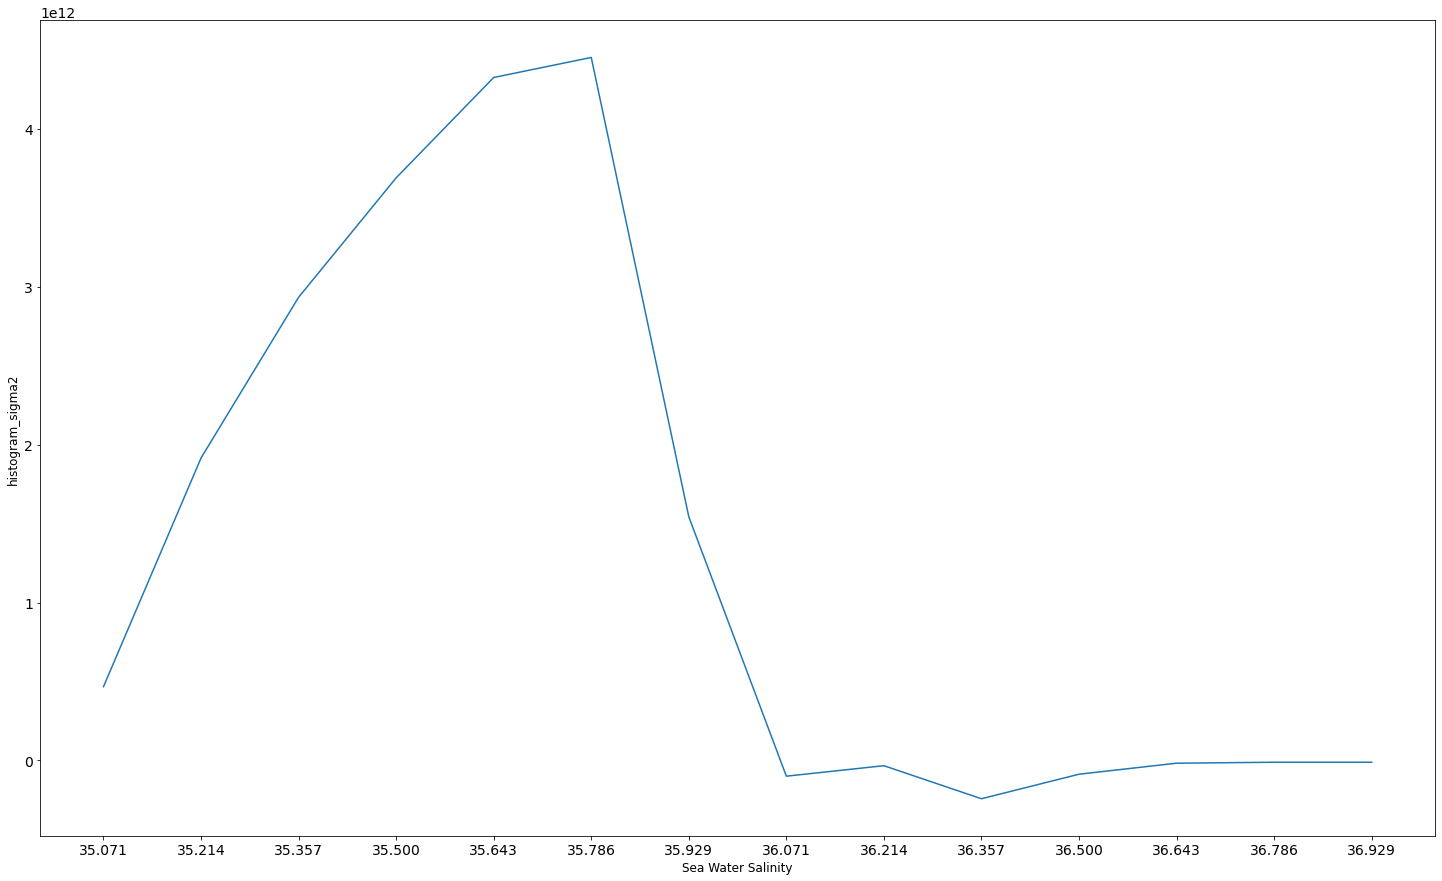

In [55]:
ds = dd['CESM2.gr.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
h2.plot(label = name)
plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
       35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
       36.785714, 36.928571])

([<matplotlib.axis.XTick at 0x7fb099fa38b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

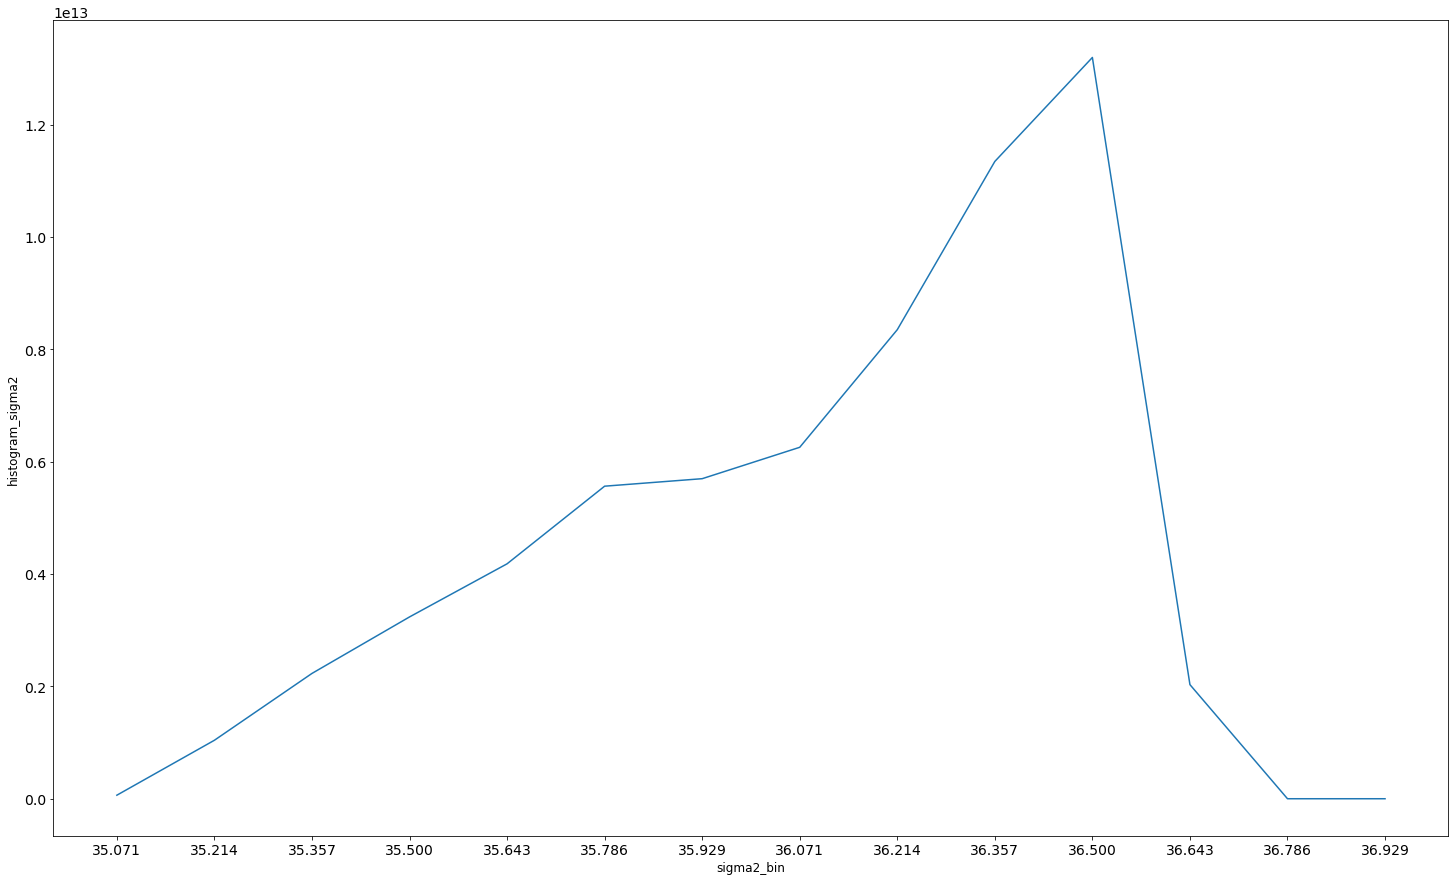

In [56]:
ds = dd['CNRM-ESM2-1.gn.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
h2.plot(label = name)
plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
       35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
       36.785714, 36.928571])

([<matplotlib.axis.XTick at 0x7fb09a5e31f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

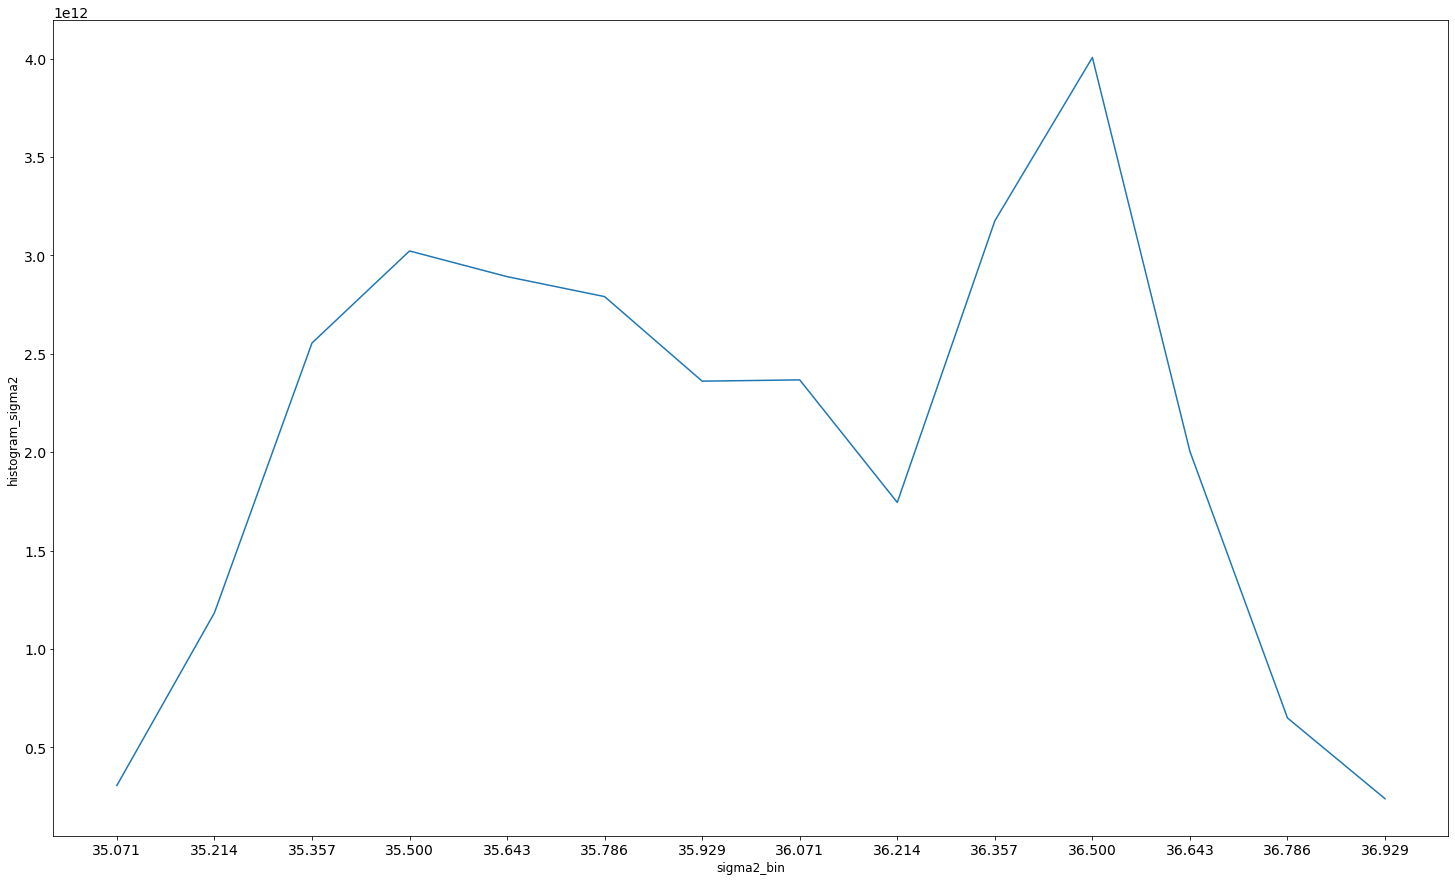

In [57]:
ds = dd['CanESM5-CanOE.gn.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
h2.plot(label = name)
plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
       35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
       36.785714, 36.928571])

([<matplotlib.axis.XTick at 0x7fb09bfa2430>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

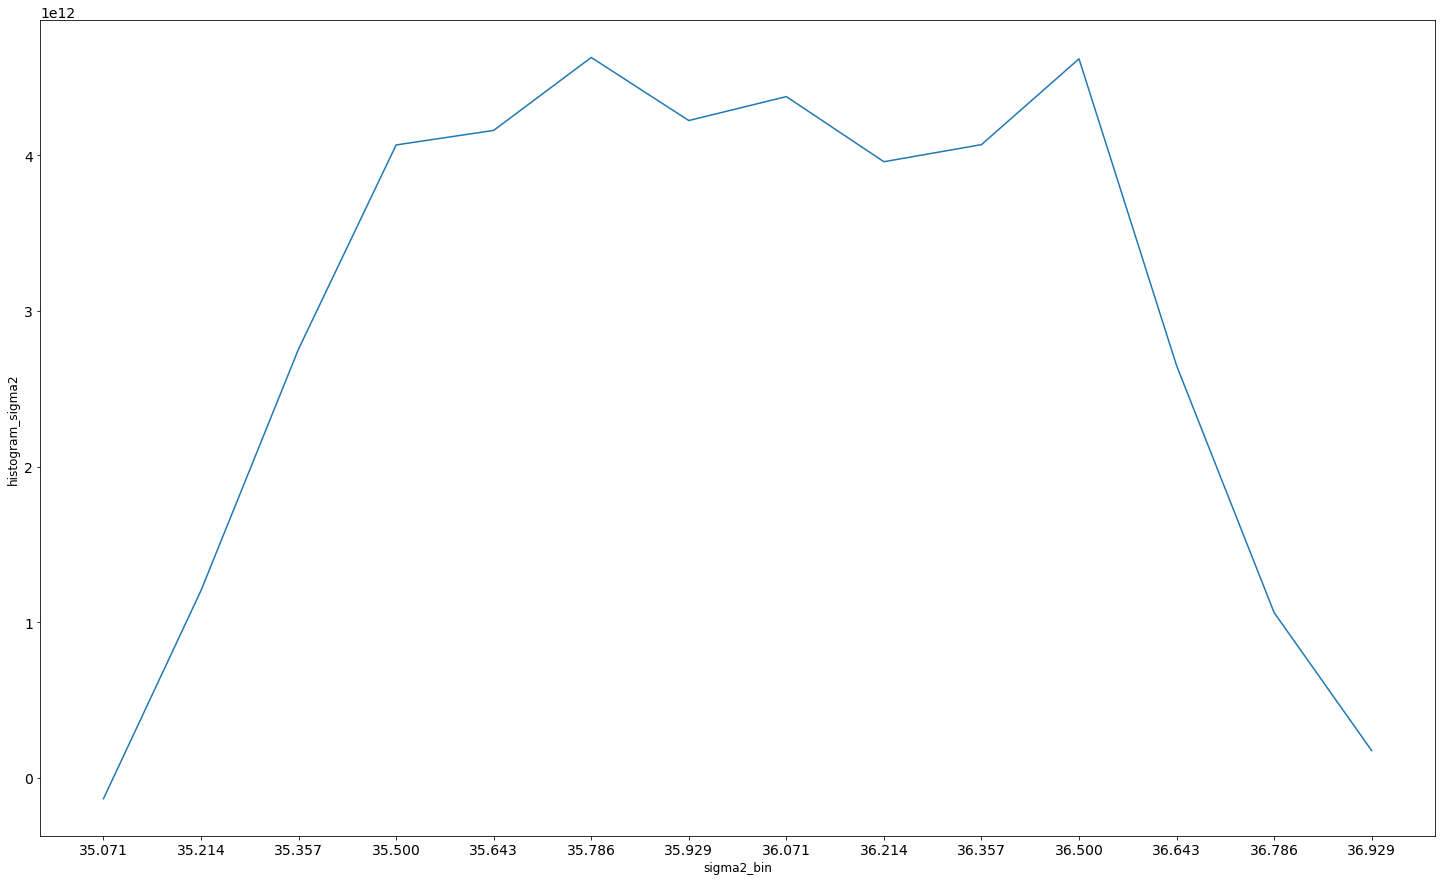

In [58]:
ds = dd['CanESM5.gn.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
h2.plot(label = name)
plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
       35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
       36.785714, 36.928571])

([<matplotlib.axis.XTick at 0x7fb09b6aab80>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

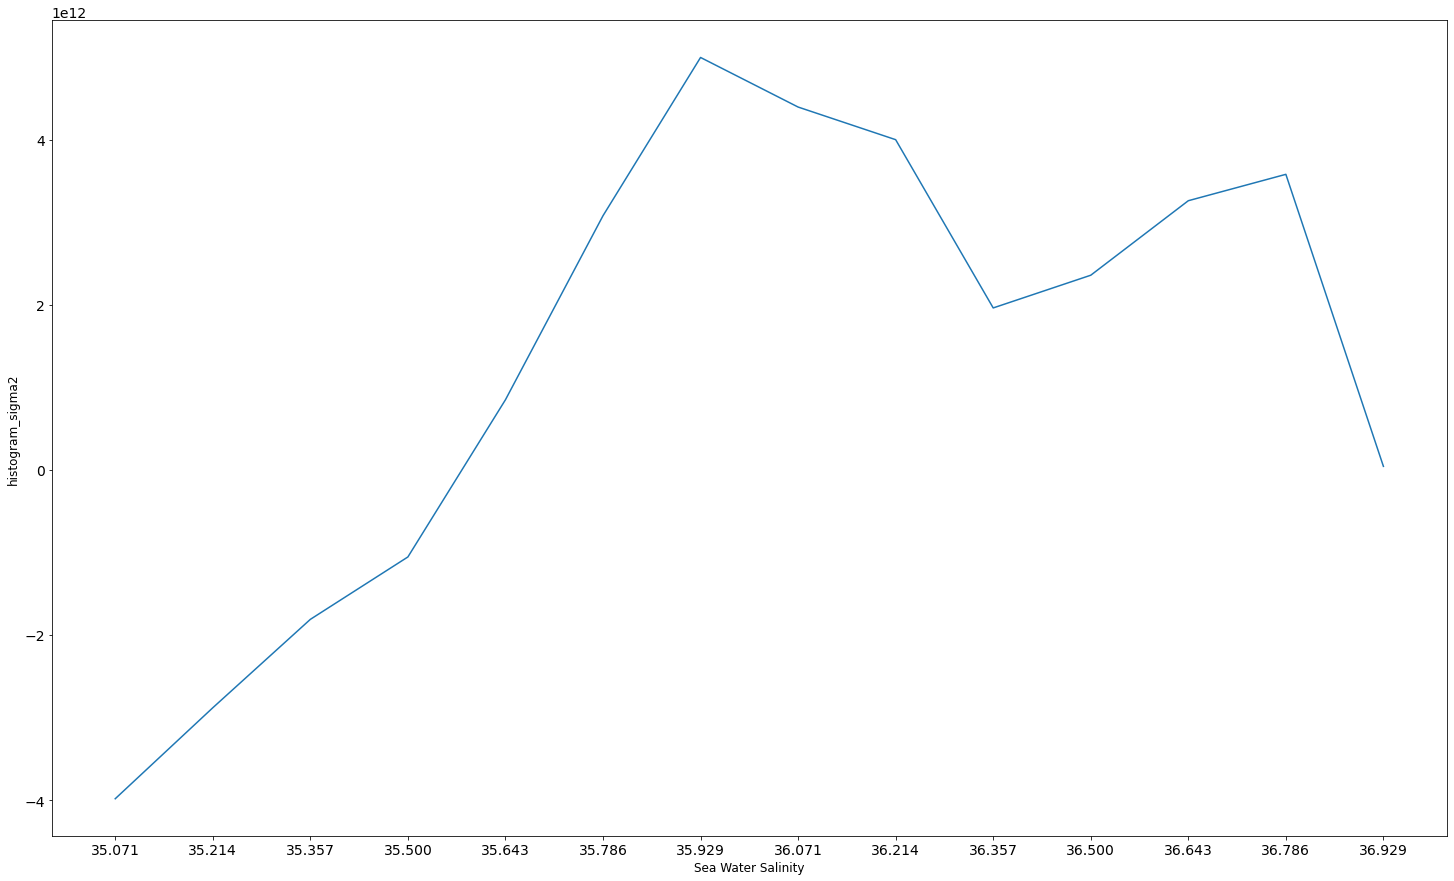

In [59]:
ds = dd['GFDL-CM4.gr.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
h2.plot(label = name)
plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
       35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
       36.785714, 36.928571])

([<matplotlib.axis.XTick at 0x7fb09b2ed730>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

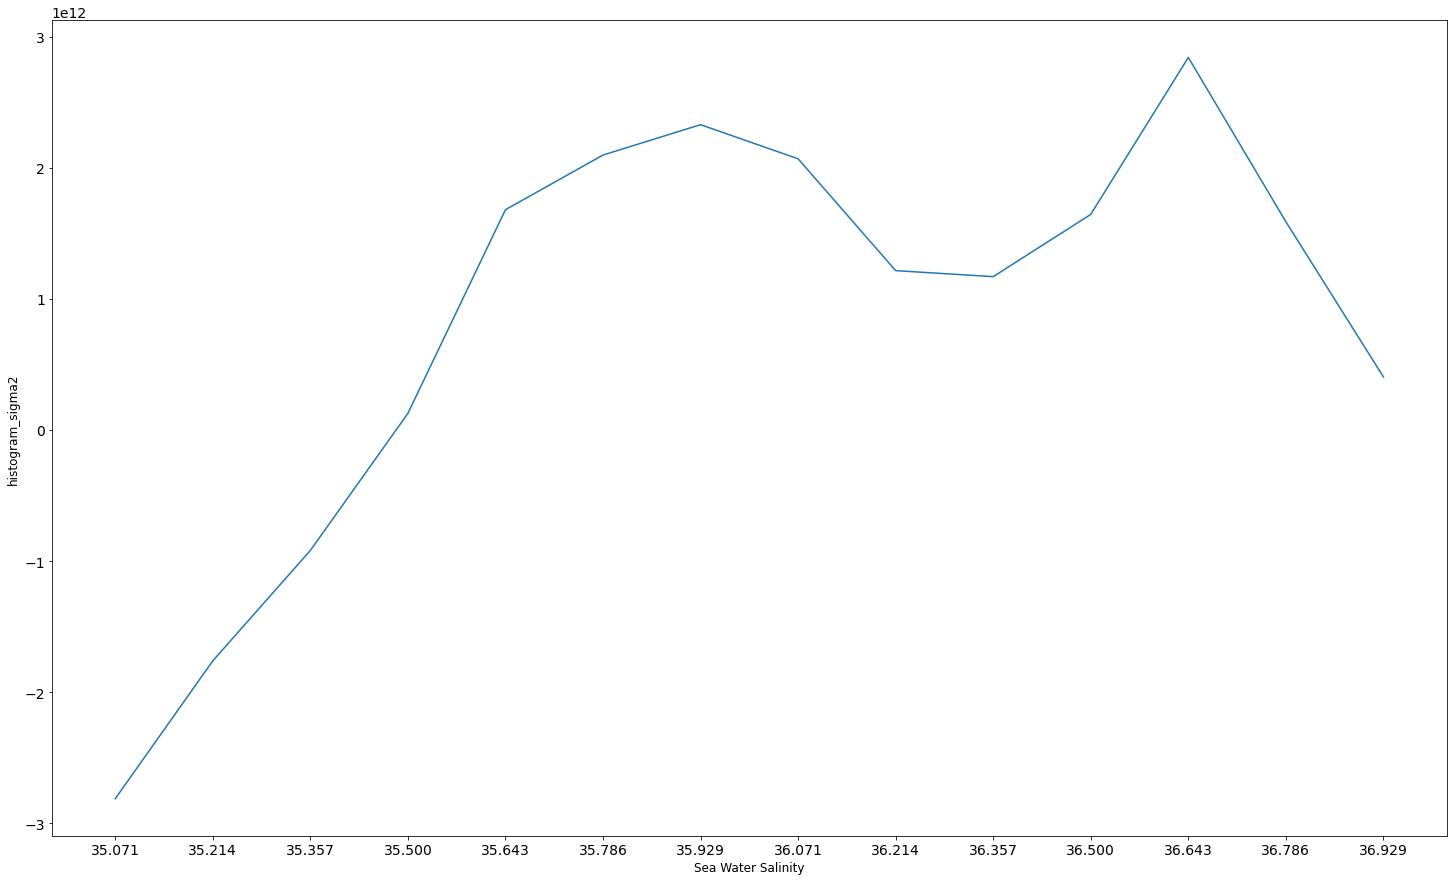

In [60]:
ds = dd['GFDL-ESM4.gr.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
h2.plot(label = name)
plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
       35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
       36.785714, 36.928571])

([<matplotlib.axis.XTick at 0x7fb09c222850>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

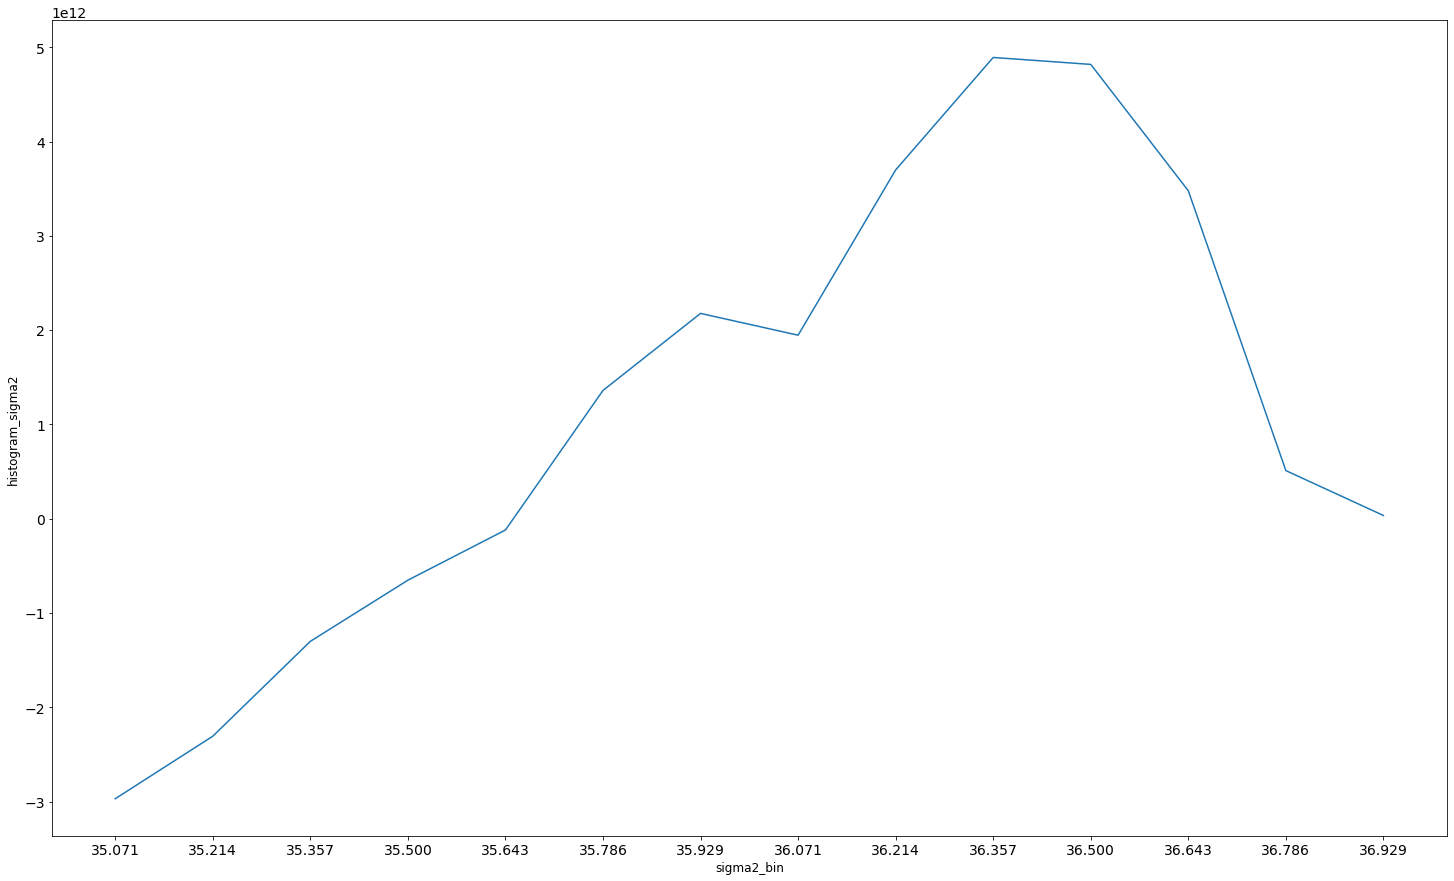

In [61]:
ds = dd['IPSL-CM6A-LR.gn.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
h2.plot(label = name)
plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
       35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
       36.785714, 36.928571])

([<matplotlib.axis.XTick at 0x7fb09a209250>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

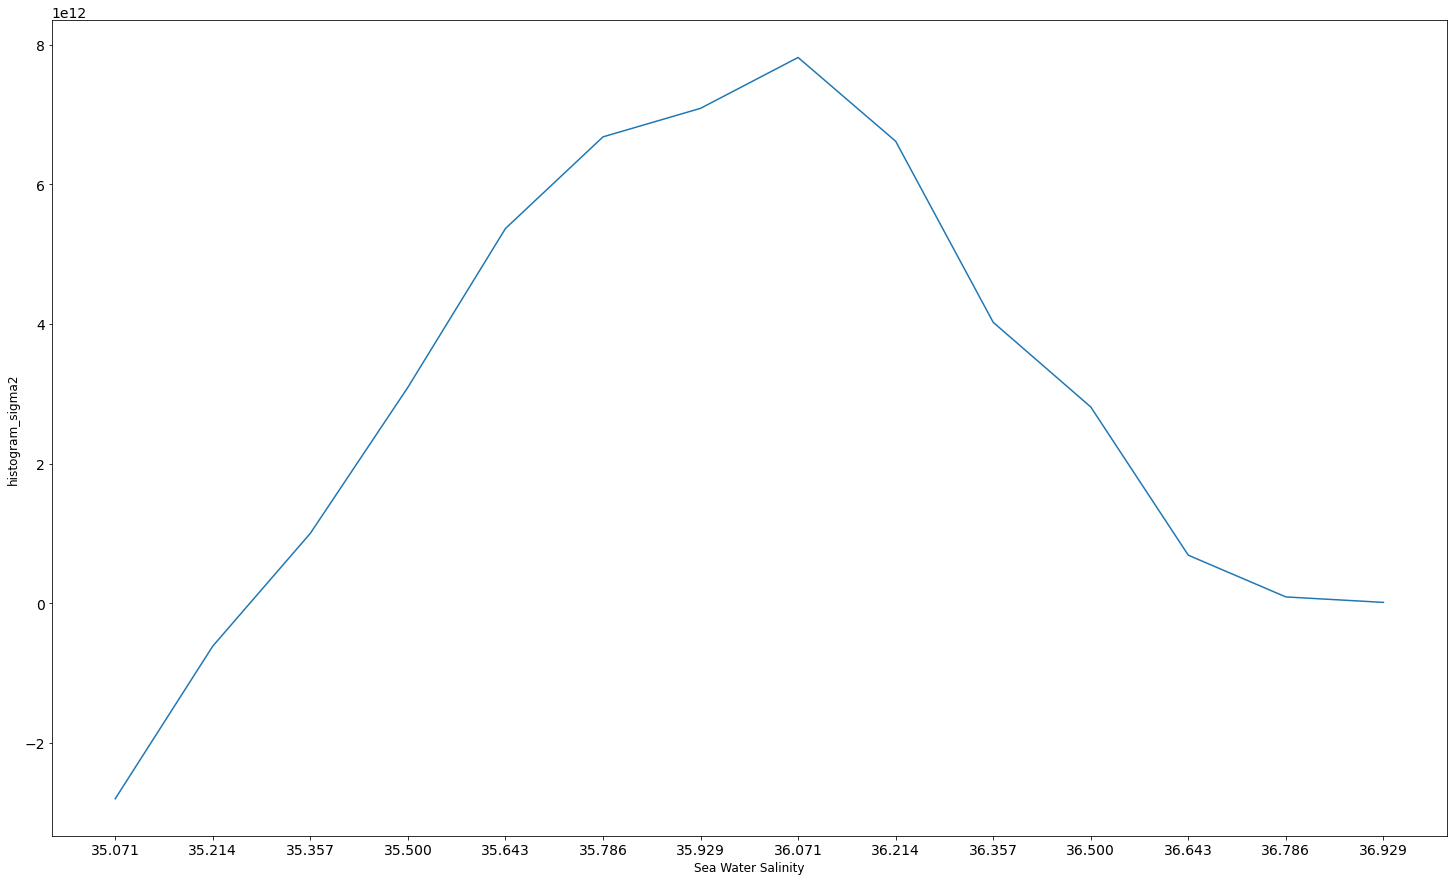

In [62]:
ds = dd['MRI-ESM2-0.gr.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
h2.plot(label = name)
plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
       35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
       36.785714, 36.928571])

([<matplotlib.axis.XTick at 0x7fb09c3ddf40>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

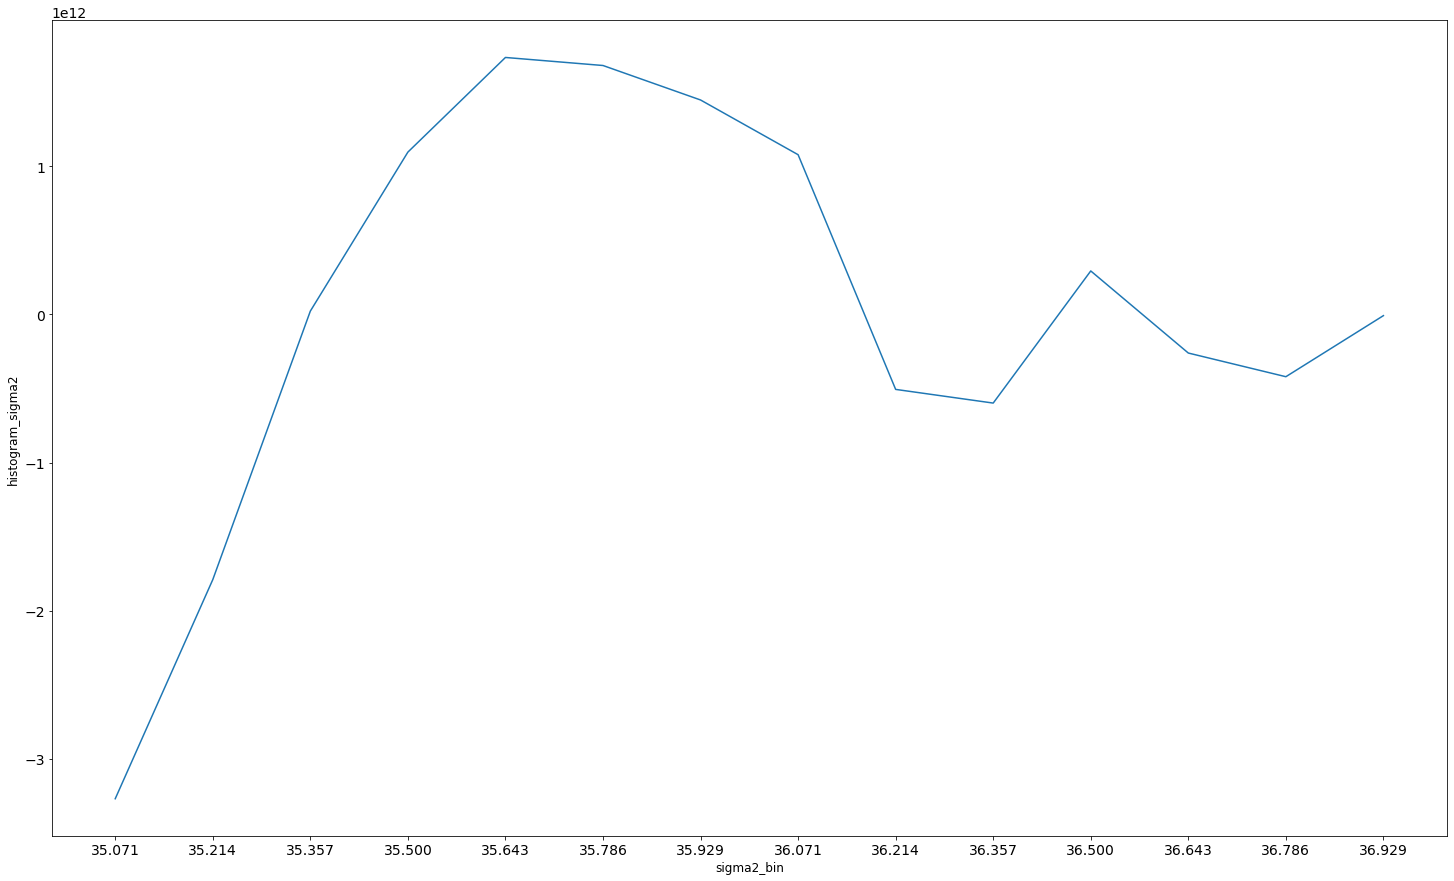

In [63]:
ds = dd['UKESM1-0-LL.gn.historical.Omon']
h2 = histogram(ds['sigma2'].isel(lev = 0)[10:60], bins = [binz], weights = -1*ds.fgco2[10:60]*A[10:60]*conversion) 
h2.plot(label = name)
plt.xticks([35.071429, 35.214286, 35.357143, 35.5     , 35.642857, 35.785714,
       35.928571, 36.071429, 36.214286, 36.357143, 36.5     , 36.642857,
       36.785714, 36.928571])